# Computing $T_g$

$T_g$ is defined as the twist number of any curve about an axis in general geometry, see Berger & Prior (2006, http://doi.org/10.1088/0305-4470/39/26/005) for details. This notebook computes $T_w$ to locate the axis of a flux rope and then uses that information to compute $T_g$ for each field line in the flux rope as below:

$T_g = \frac{1}{2\pi}\int_{x}\frac{d\phi}{ds} = \frac{1}{2\pi}\int_{x}\mathbf{\hat{T}}(s)\cdot\mathbf{\hat{V}}(s)\times\frac{d\mathbf{\hat{V}}(s)}{ds}ds$

Here the unit tangent vector, $\mathbf{\hat{T}}$, is the magnetic field unit vector, $\mathbf{\hat{B}}$, at the axis of the flux rope. The unit normal vector, $\mathbf{\hat{V}}$, is between the axis and the field line of interest.

In [1]:
import k3d
import mafiat.twist as mt
import math
import matplotlib.pyplot as plt
import numpy as np
import pysmsh.difference.staggered
import pysmsh.interpolate.staggered
import pysmsh.interpolate.trilinear
import pysmsh.tools.streamtracer
import scipy.constants

from mafiat.io import Reader
from mafiat.plot import plot_2d_map
from mafiat.tools import trace_field_line

Here we set options to increase plot readability.

In [2]:
import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 'large'

## Load Simulation Data

First we, optionally, download the sample data if not already present. Note that this file is 259 MB.

In [3]:
import os
import urllib.request
if not os.path.exists('../sample_data/sample.npz'):
    if not os.path.exists('../sample_data'): os.mkdir('../sample_data/')
    urllib.request.urlretrieve('https://drive.google.com/uc?export=download&confirm=9_s_&id=1XRdSf7HQCRo5aPIq9hMi8QnjFC0oiinl',
                               '../sample_data/sample.npz')

Next we read in the magnetic field data. The default case uses a legacy reader compatible with the provided sample data.

In [4]:
data = Reader()

In [5]:
data.read("../sample_data/sample.npz",
          vector_fields={"B": "face_staggered"})

Next we create an alias to the magnetic field data to avoid having to edit all of the references in the notebook when using different inputs.

In [6]:
data.mag_field = data.B

Note that here we replace any zero values in the magnetic field data passed to the interpolator with NaN to avoid division by zero errors in the $T_w$ computation. The original Bz is stored for compatibility with plotting routines.

In [7]:
for i in range(len(data.mag_field.data)):
    zeros = np.where(data.mag_field.data[i] == 0)
    if len(zeros[0]) != 0:
        if i == 2: 
            Bz_old = np.copy(data.mag_field.data[2])
        data.mag_field.data[i][zeros] = float('nan')
        print(f'Zeroes were found in the input data of index {i}. They have been changed to NaNs.')

Zeroes were found in the input data of index 0. They have been changed to NaNs.
Zeroes were found in the input data of index 1. They have been changed to NaNs.
Zeroes were found in the input data of index 2. They have been changed to NaNs.


Next we plot $B_z$ to check for any issues with the loading process.

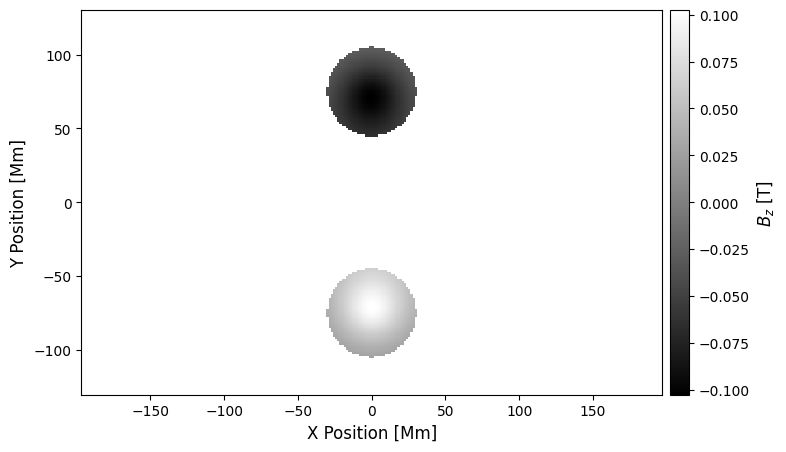

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_2d_map(data.mag_field.data[2][:,:,0], crds=(data.mesh.centers.x, data.mesh.centers.y), 
            cmap='gray', clabel='$B_z$ [T]', ax=ax)

### Compute Current Density

In [9]:
current_density = pysmsh.Field.Vector(data.mesh, "edge_staggered")
pysmsh.difference.staggered.curl(data.mag_field, current_density)
for component in current_density.data:
    component *= 1.0/scipy.constants.mu_0

### Create Interpolators For The Data

In [10]:
class EmptyContainer: pass
interpolator = EmptyContainer()

Staggered magnetic field interpolation for the magnetic field. 

In [11]:
interpolator.mag_field = pysmsh.interpolate.staggered.FaceStaggeredInterpolator(data.mag_field)

Trilinear interpolation for the current density

In [12]:
interpolator.current_density = pysmsh.interpolate.trilinear.EdgeStaggeredInterpolator(current_density)

## Computing $T_w$

In [13]:
Tw = mt.TwCompute(interpolator.mag_field, interpolator.current_density)

Next we define the location of the lower boundary to avoid numba errors. This is the boundary where any points below are considered to originate from the photosphere.

In [14]:
lower_boundary = data.mesh.indomain_extent.z[0] + data.mesh.spacing.z[0]/2

This cell assists with defining the location of the 2D plane for the $T_w$ computation. Change the definition of 'target' as necessary with the axis and its intercept in metres. For example, {'y', 0e6}, will provide a plane at y=0. The resulting output will be carried forward for you.

In [15]:
print('The shape of your domain is:')
print(np.shape(data.mesh.indomain_centers.x), np.shape(data.mesh.indomain_centers.y), np.shape(data.mesh.indomain_centers.z))
target = ('y', 0e6)
finder = {'x' : np.abs(data.mesh.indomain_centers.x - target[1]).argmin(),
          'y' : np.abs(data.mesh.indomain_centers.y - target[1]).argmin(),
          'z' : np.abs(data.mesh.indomain_centers.z - target[1]).argmin()}
found = finder.get(target[0], 'invalid axis specified.')
print('The closest '+target[0]+' index to '+str(target[1])+' is '+str(found))

The shape of your domain is:
(266,) (175,) (229,)
The closest y index to 0.0 is 87


Here we construct the domain of the $T_w$ plane. The default resolution is 200 points in each dimension.

In [16]:
map_points = (200, 200, 200)

if target[0] == 'x':
    x_crds = target[1]
    y_crds = np.linspace(data.mesh.indomain_centers.y[0], data.mesh.indomain_centers.y[-1], map_points[1])
    z_crds = np.linspace(data.mesh.indomain_centers.z[0], data.mesh.indomain_centers.z[-1], map_points[2])
elif target[0] == 'y':
    x_crds = np.linspace(data.mesh.indomain_centers.x[0], data.mesh.indomain_centers.x[-1], map_points[0])
    y_crds = target[1]
    z_crds = np.linspace(data.mesh.indomain_centers.z[0], data.mesh.indomain_centers.z[-1], map_points[2])
elif target[0] == 'z':
    x_crds = np.linspace(data.mesh.indomain_centers.x[0], data.mesh.indomain_centers.x[-1], map_points[0])
    y_crds = np.linspace(data.mesh.indomain_centers.y[0], data.mesh.indomain_centers.y[-1], map_points[1])
    z_crds = target[1]
else:
    print('Invalid target axis specified.')

This ensures the axes are fed into the $T_w$ computation function in the correct order, such that the third axis is always that chosen by 'target'.

In [17]:
coords = [x_crds, y_crds, z_crds]
if len(np.shape(x_crds)) == 0:
    order = (1, 2, 0)
elif len(np.shape(y_crds)) == 0:
    order = (0, 2, 1)
elif len(np.shape(z_crds)) == 0:
    order = (0, 1, 2)
else:
    print('Invalid input.')
if order: print(order)

(0, 2, 1)


Now we define the field line tracer and compute the map of $T_w$ for the selected plane. Note that with default settings, this will take approximately four minutes for the sample data. You can optionally speed it up by increasing the step size of the field line tracer, most easily by increasing 'relative_step_size'.

In [18]:
%%time
tracer = pysmsh.tools.streamtracer.MidPointStreamLineTracer(max_path_length=400.0e6, min_step_size=1e6, relative_step_size=0.5)
Tw_map, is_closed, list_of_seed_points, Bz = mt.compute_Tw_map(coords[order[0]], coords[order[1]], coords[order[2]], 
                                                           order, interpolator.mag_field, tracer, Tw, lower_boundary)

CPU times: user 3min 5s, sys: 1.38 s, total: 3min 6s
Wall time: 3min 20s


Here we quickly check the extremes of the $T_w$ computation for reference.

In [19]:
np.nanmax(Tw_map), np.nanmin(Tw_map)

(1.5628000709836702, 0.0)

## Finding the Flux Rope Axis

Here we plot the resultant $T_w$ plane using a custom plotting function. Options are defined below to facilitate easily updating all of the plots, but they can be individually edited if needed.

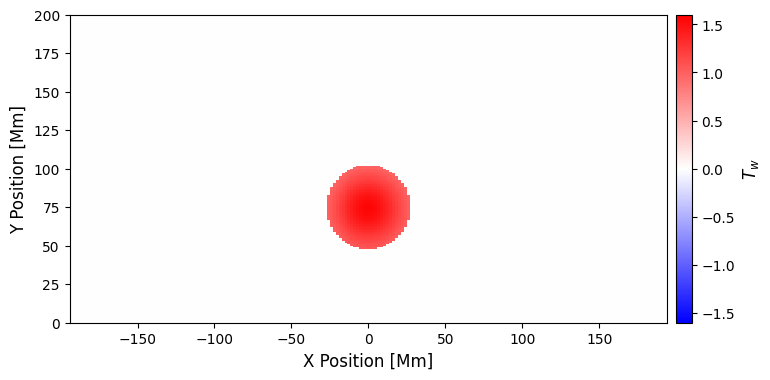

In [20]:
xlim = None # Limits in x of the form [-25, 25].
ylim = None # Limits in y of the form [50, 100].
clim = [-1.6, 1.6] # [vmin, vmax] of the pcolormesh.
plot_2d_map(Tw_map, crds=(coords[order[0]], coords[order[1]]), clim=clim, xlim=xlim, ylim=ylim, clabel='$T_w$')

Step 1: Remove open field lines, i.e., any lines that reach a boundary other than the lower boundary defined earlier.

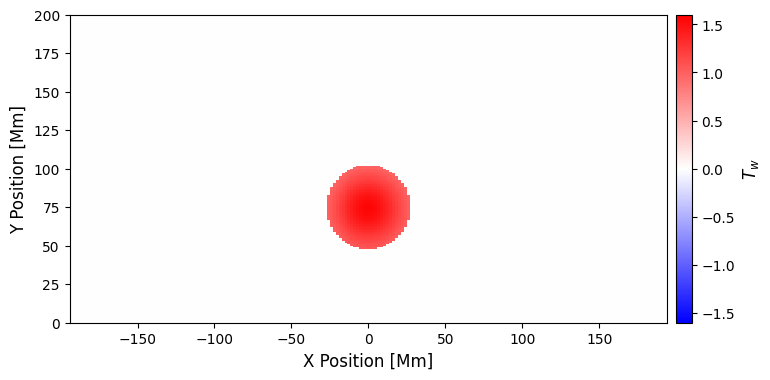

In [21]:
Tw_step_1 = np.copy(Tw_map)*is_closed
plot_2d_map(Tw_step_1, crds=(coords[order[0]], coords[order[1]]), clim=clim, xlim=xlim, ylim=ylim, clabel='$T_w$')

Step 2: Remove regions of small twist, i.e., potential-like or slightly sheared fields.

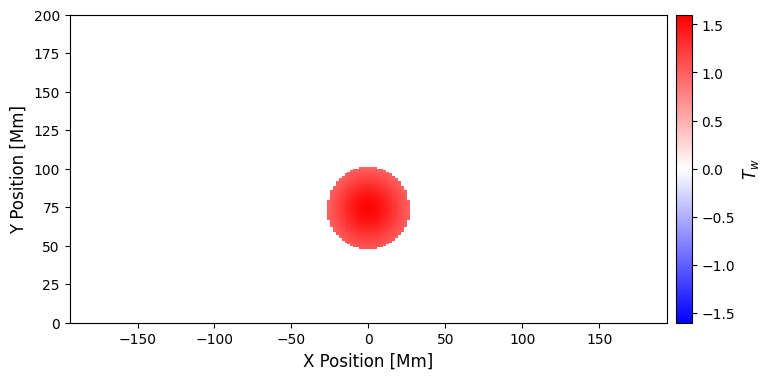

In [22]:
Tw_step_2 = np.copy(Tw_step_1)
Tw_step_2[np.where(np.abs(Tw_step_2) < 0.99)] = 0.0
plot_2d_map(Tw_step_2, crds=(coords[order[0]], coords[order[1]]), clim=clim, xlim=xlim, ylim=ylim, clabel='$T_w$')

Step 3: Remove regions that belong to the same flux rope, i.e., we only want one leg so we check $B_z$ because it should be opposite at each leg. If you do not have a horizontal map then this step is automatically skipped.

Note: Change between < and > if the other footpoint is better defined.

Not a horizontal slice so skipping this step.


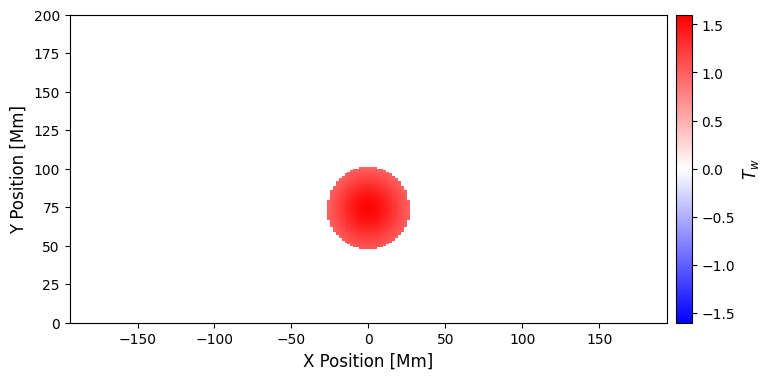

In [23]:
Tw_step_3 = np.copy(Tw_step_2)
if order[1] != 2:
    Tw_step_3[np.where(Bz > 0.0)] = 0.0
else:
    print('Not a horizontal slice so skipping this step.')
plot_2d_map(Tw_step_3, crds=(coords[order[0]], coords[order[1]]), clim=clim, xlim=xlim, ylim=ylim, clabel='$T_w$')

Step 4: Remove any points that have the wrong sign of $T_w$, e.g., remove the negative points if your flux rope is positively twisted.

In [24]:
twSign = 1 # 1 to keep positive points and -1 to keep negative points.

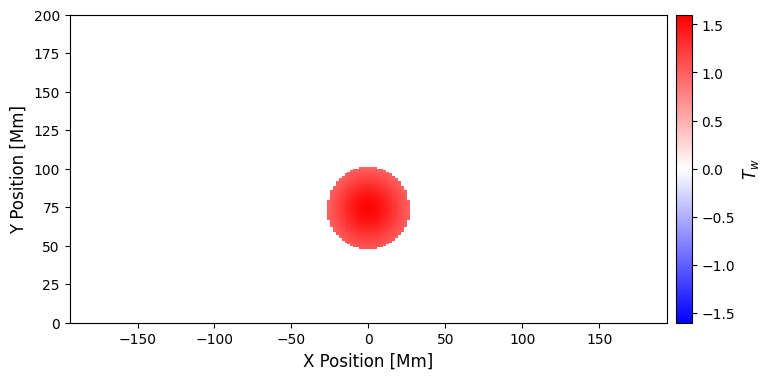

In [25]:
Tw_step_4 = np.copy(Tw_step_3)
if twSign == 1:
    Tw_step_4[np.where(Tw_step_4 < 0.0)] = 0
    plot_2d_map(Tw_step_4, crds=(coords[order[0]], coords[order[1]]), clim=clim, xlim=xlim, ylim=ylim, clabel='$T_w$')
elif twSign == -1:
    Tw_step_4[np.where(Tw_step_4 > 0.0)] = 0
    plot_2d_map(Tw_step_4, crds=(coords[order[0]], coords[order[1]]), clim=clim, xlim=xlim, ylim=ylim, clabel='$T_w$')
else:
    print('Please enter a valid value for twSign.')

Step 5: Manual trimming. This is where we remove any other points that do not correspond to the flux rope by manually setting them to zero. There is a degree of trial and error but we can simply run the next cell again if we make a mistake to try again.

In [26]:
Tw_step_5 = np.copy(Tw_step_4)

Here we plot the plane again but with index-based axes to assist with aiming the manual trimming.

Text(0, 0.5, 'Y Position [index]')

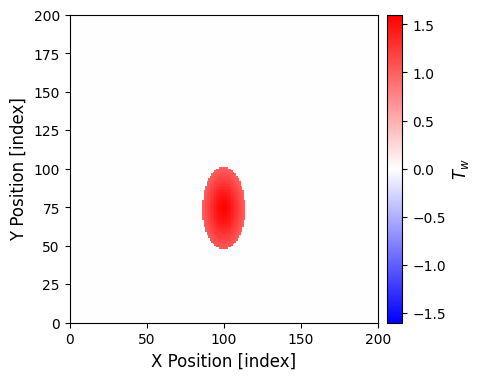

In [27]:
plot_2d_map(Tw_step_5, crds=(np.arange(len(coords[order[0]])+1)*1e6, np.arange(len(coords[order[1]])+1)*1e6), clim=clim, clabel='$T_w$')
ax = plt.gca()
ax.set_xlabel('X Position [index]')
ax.set_ylabel('Y Position [index]')


Here we perform the manual trimming as indicated by the commented out examples and then we plot the final result. These two cells can be repeated as many times as necessary, the trimming doesn't have to be perfect in the first instance.

In [28]:
#Tw_step_5[0:100,:] = 0
#Tw_step_5[200:,:] = 0
#Tw_step_5[:,0:92] = 0
#Tw_step_5[:,170:] = 0

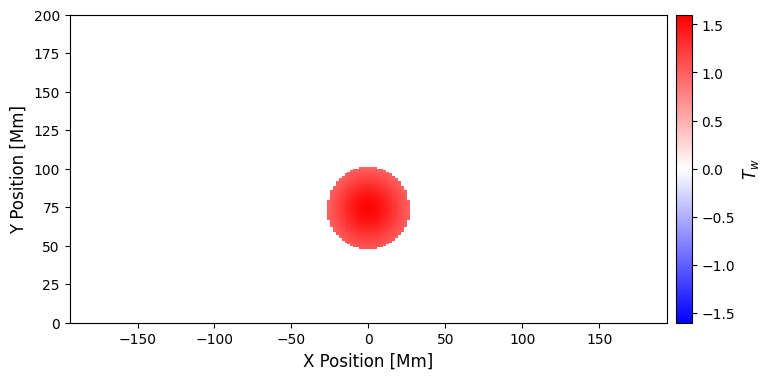

In [29]:
plot_2d_map(Tw_step_5, crds=(coords[order[0]], coords[order[1]]), clim=clim, xlim=xlim, ylim=ylim, clabel='$T_w$')

When we are happy with our flux rope cross section, save the coordinates.

In [30]:
fr_defining_points = list()

if twSign == 1:
    for idx in np.ravel_multi_index(np.where(Tw_step_5 > 0.5), Tw_step_5.shape):
        fr_defining_points.append(list_of_seed_points[idx])
elif twSign == -1:
    for idx in np.ravel_multi_index(np.where(Tw_step_5 < -0.5), Tw_step_5.shape):
        fr_defining_points.append(list_of_seed_points[idx])

Assuming that the FR axis is at an extremum in $T_w$. Recompute $T_w$ around the footpoint at a higher resolution. Here 'x' and 'y' refers to the axes of the plots above, not to the axes of the simulation domain.

In [31]:
x_crds_hres = np.linspace(-34.0e6, 35.0e6, 200)
y_crds_hres = np.linspace(41.0e6, 110.0e6, 200)

With default settings, this computation of the higher-resolution map will take approximately four minutes for the sample data.

In [32]:
%%time
tracer = pysmsh.tools.streamtracer.MidPointStreamLineTracer(max_path_length=400.0e6, min_step_size=1e6, relative_step_size=0.4)
Tw_map_h, is_closed_h, list_of_seed_points_h, _ \
    = mt.compute_Tw_map(x_crds_hres, y_crds_hres, coords[order[2]], order,
                     interpolator.mag_field, tracer, Tw, lower_boundary)

CPU times: user 2min 37s, sys: 1.25 s, total: 2min 38s
Wall time: 2min 50s


Now we plot the higher resolution $T_w$ along with contours in an attempt to highlight the axis. The default contour colours are designed to be visible on top of the map plot but can be changed if necessary by editing 'ccolors'. The default contour levels, 'clevels', are chosen for the sample data and may need changing to zero in on the axis of other flux ropes.

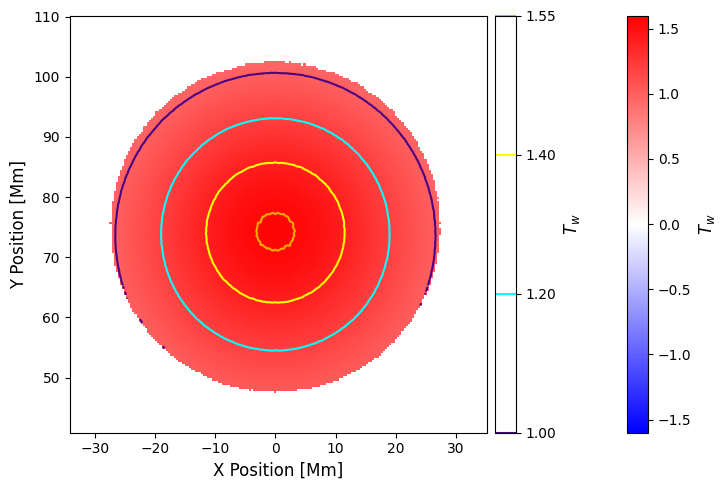

In [33]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 5))
plot_2d_map(Tw_map_h, crds=(x_crds_hres, y_crds_hres), clim=(-1.6, 1.6), clabel='$T_w$', ax=ax)
clevels = (1.0, 1.2, 1.4, 1.55) # Contour levels from smallest to largest.
ccolors = ('indigo', 'cyan', 'yellow', 'orange') # Note that this is reversed for negative Tw for visibility.

if twSign == -1:
    ccolors = ccolors[::-1]

pc = ax.contour(x_crds_hres/1e6, y_crds_hres/1e6, Tw_map_h.T,
                    levels=clevels, colors=ccolors)

cbar1 = fig.colorbar(pc, pad=0.01, ax=ax)
fig.tight_layout()
cbar1.set_label('$T_w$')

Now we manually select the contour that we believe corresponds to the axis of the FR and compute the median centre to use as the coordinates of the axis. For this reason, you may want to repeat the step above until the contour is relatively small and well-defined.

If you have 4 contour levels, as is the default, then in pc.allsegs[x][y] x corresponds to the level (0 to 3) and y corresponds to each contour at that level. If there are multiple y values you identify the correct one with trial and error because the axis dot will be shown below in lime green.

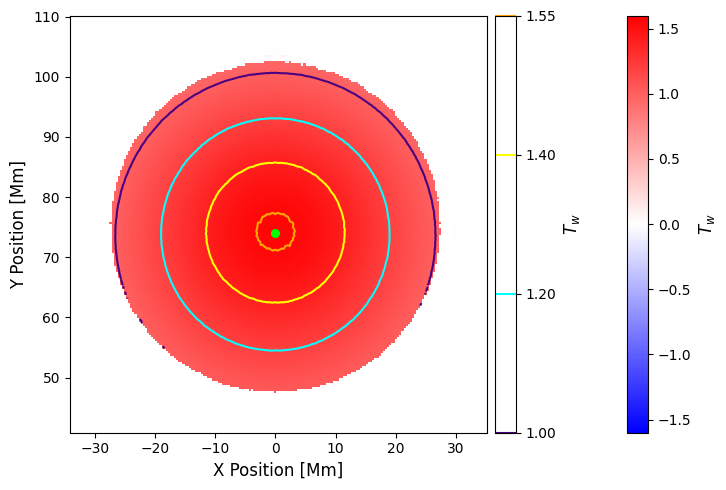

In [34]:
island = pc.allsegs[3][0]
island_center = (np.median(island[:, 0]), np.median(island[:, 1]))
ax.scatter(island_center[0], island_center[1], s=30, c='lime')
fig

## Interactively Visualise in 3D

First we setup the visualisation and then the ensuing steps add plots to it.

In [35]:
vis = k3d.plot(grid_auto_fit=False, 
               grid=(data.mesh.indomain_extent.x[0]/1e6, data.mesh.indomain_extent.y[0]/1e6, data.mesh.indomain_extent.z[0]/1e6, 
                     data.mesh.indomain_extent.x[-1]/1e6, data.mesh.indomain_extent.y[-1]/1e6, data.mesh.indomain_extent.z[-1]/1e6))

Plot $B_z$ at the bottom of the simulation. Note that NaNs should not be input so we check if we inserted any at the start.

In [36]:
if 'Bz_old' in locals():
    temp_data = Bz_old[2:-2, 2:-2, 5]
else:
    temp_data = data.mag_field.data[2][:,:,0]

plot_Bz_bottom = k3d.texture(attribute=1e4*temp_data.T,
                             bounds=(data.mesh.indomain_extent.x[0]/1e6, data.mesh.indomain_extent.x[-1]/1e6, 
                                     data.mesh.indomain_extent.y[0]/1e6, data.mesh.indomain_extent.y[-1]/1e6),
                             color_map=k3d.colormaps.matplotlib_color_maps.Gray,
                             color_range=[-1000, 1000])

In [37]:
vis += plot_Bz_bottom

Initialise a new tracer and trace the flux rope axis selected from the contours.

In [38]:
tracer = pysmsh.tools.streamtracer.MidPointStreamLineTracer(max_path_length=400.0e6, min_step_size=1e6, record_points=True)

In [39]:
if order == (0, 1, 2):
    axis_seed = (island_center[0]*1e6, island_center[1]*1e6, coords[order[2]])
elif order == (0, 2, 1):
    axis_seed = (island_center[0]*1e6, coords[order[2]], island_center[1]*1e6)
elif order == (1, 2, 0):
    axis_seed = (coords[order[2]], island_center[0]*1e6, island_center[1]*1e6)

axis_coordinates = trace_field_line(axis_seed, interpolator.mag_field, tracer)

axis_field_line \
    = k3d.line(np.dstack(axis_coordinates)[0].astype(np.float32)/1e6, 
               shader='mesh', width=1.0, color=0xaaaaaa)

In [40]:
axis_field_line.width = 6.0
vis += axis_field_line

Trace field lines from the rest of the footpoints for plotting to judge the axis selection. Note the step size in the for loop can be reduced to include more lines.

In [41]:
field_lines = list()
for seed in fr_defining_points[::20]:
    
    field_line_crds = trace_field_line(seed, interpolator.mag_field, tracer)
    
    field_lines.append(k3d.line(np.dstack(field_line_crds)[0].astype(np.float32)/1e6, 
                                shader='mesh', width=1.0))

In [42]:
for field_line in field_lines:
    vis += field_line

Here we give each of the field lines a random colour so they're easier to follow.

In [43]:
np.random.seed(24390)

for line in field_lines:
    line.color = np.random.randint(100, 0xffffff)

Finally we display the interactive plot. Note the controls in the top right corner which provide many options, including the possibility to make a shareable HTML file (Controls -> Snapshot HTML) that reproduces the plot.

In [44]:
vis.display()

Output()

## Calculate $T_g$

Next we ensure that any ghost layers in our simulation data are removed from the axis coordinates.

In [45]:
if len(np.where(np.array(axis_coordinates[2]) < 0)[0]) > 0:
    print("Negative z values detected. Removing those coordinates.")
    pos = np.where(np.array(axis_coordinates[2]) >= 0)
    axis_coordinates = [np.array(axis_coordinates[i])[pos].tolist() for i in range(0,3)]

Calculate the unit tangent vector along the FR axis, $\hat{B}$. This remains the same for all computations of $T_g$ with a given axis.

In [46]:
Bhat = []
for i in range(len(axis_coordinates[0])):
    tBhat = interpolator.mag_field.cartesian_unit_vector((axis_coordinates[0][i], axis_coordinates[1][i], axis_coordinates[2][i]))
    Bhat.append(tBhat)

Compute $T_g$ for all field lines in the FR.

Here we find all of the unit normal vectors for each point along the axis traced above to each field line. We first loop through each point from the 2D $T_w$ plane stored in fr_defining_points and trace the corresponding field lines at a higher resolution than the axis.

The rotation sensitivity (rotsens, the maximum angle between consecutive unit normal vectors) or the search interval (interval) may need adjusting when using other data if the function has difficulty.

Note that accuracy will increase with a smaller step size, but the defaults below return a good result with a reasonable computation time of approximately eight minutes.

In [47]:
%%time
rotsens = 35
Vhat = []
BdV = []
indexes = []
fl_crds = []
tracer.min_step_size = 1e6
tracer.relative_step_size=0.02
for seed in fr_defining_points:
    field_line_crds = trace_field_line(seed, interpolator.mag_field, tracer)
    # Factor out the ghost layer if necessary.
    if len(np.where(np.array(field_line_crds[2]) < 0)[0]) > 0:
        print("Negative z values detected. Removing those coordinates.")
        pos = np.where(np.array(field_line_crds[2]) >= 0)
        field_line_crds = [np.array(field_line_crds[i])[pos].tolist() for i in range(0,3)]
    fl_crds.append(field_line_crds)
    interval = int(len(field_line_crds[0])/len(axis_coordinates[0]))*2
    Vhat2, BdV2, ind2 = mt.find_V(axis_coordinates, field_line_crds, Bhat, interval, rotsens)
    Vhat.append(Vhat2)
    BdV.append(BdV2)
    indexes.append(ind2)

Negative z values detected. Removing those coordinates.
Negative z values detected. Removing those coordinates.
Negative z values detected. Removing those coordinates.
Negative z values detected. Removing those coordinates.
Negative z values detected. Removing those coordinates.
Negative z values detected. Removing those coordinates.
Negative z values detected. Removing those coordinates.
Negative z values detected. Removing those coordinates.
Negative z values detected. Removing those coordinates.
Negative z values detected. Removing those coordinates.
Negative z values detected. Removing those coordinates.
Negative z values detected. Removing those coordinates.
Negative z values detected. Removing those coordinates.
Negative z values detected. Removing those coordinates.
Negative z values detected. Removing those coordinates.
Negative z values detected. Removing those coordinates.
Negative z values detected. Removing those coordinates.
Negative z values detected. Removing those coord

In [48]:
Tg, Tg_comps, _ = mt.calc_Tg(Bhat, Vhat, axis_coordinates)

## Checks

These are optional checks on the outputs from above which make sure that the unit vectors are actually unit vectors.

In [49]:
Bhat_check = []
for ac in range(len(Bhat)):
    Bhat_check.append(np.linalg.norm(Bhat[ac]))
if not np.allclose(np.min(Bhat_check), 1):
    print('One or more axial unit tangent vectors have length less than 1.')

In [50]:
Vhat_check = []
for fl in range(len(Vhat)):
    for ac in range(len(Vhat[fl])):
        Vhat_check.append(np.linalg.norm(Vhat[fl][ac]))
if not np.allclose(np.min(Vhat_check), 1):
    print('One or more unit normal vectors have length less than 1.')

Here we can plot the angles between the unit tangent vectors and unit normal vectors at each point along the axis for the target field line (test_fl) to check the results of the 'find_V' function. Presently, some deviation is normal at the footpoints otherwise deviating from approximately 90 degrees suggests the function was unsuccessful for the input and parameters selected.

Text(0, 0.5, 'acos(BdotV) [deg]')

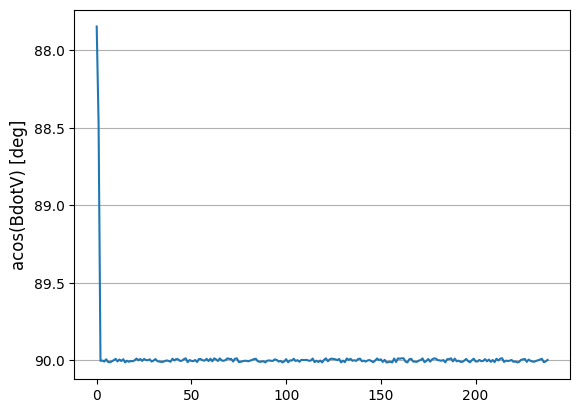

In [51]:
test_fl = 0 # The field line to examine.
test = [math.degrees(math.acos(x)) for x in BdV[test_fl]]
plt.plot(test)
ax1 = plt.gca()
ax1.invert_yaxis()
ax1.yaxis.grid()
ax1.set_ylabel('acos(BdotV) [deg]')

## Save Results

Here we output the important variables to a file compatible with the visualisation notebook.

In [52]:
vars = ['coords', 'order', 'Tw_step_5', 'fr_defining_points',
        'axis_seed', 'axis_coordinates',
        'rotsens', 'Bhat', 'Vhat', 'BdV', 'indexes', 'fl_crds',
        'Tg', 'Tg_comps', 'ccolors', 'clevels']

In [53]:
out_path = '../sample_data/sample_tg.npz'

In [54]:
# To remove npyio VisibleDeprecationWarnings about ragged nested sequences.
coords = np.array(coords, dtype='object')
fl_crds = np.array(fl_crds, dtype='object')

In [55]:
write_vars = []
for var in vars:
    if var in globals():
        write_vars.append(var)
np.savez(out_path, **{name:eval(name) for name in write_vars})
